In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')
sys.path.append('../src')
from config import *
from data_utils import *
from preprocessing import *
from eda_utils import *
from loguru import logger

In [87]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [90]:
logger.remove()  # Remove default handler
logger.add(sys.stdout, level="INFO", format="<green>{time:YYYY-MM-DD HH:mm:ss}</green> | <level>{level: <8}</level> | <cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - <level>{message}</level>")
logger.add("reliability_analysis.log", level="DEBUG", rotation="10 MB")
logger.info("Starting Monthly Reliability Metrics Analysis with Loguru")

2025-11-22 13:07:43 | INFO     | __main__:<module>:4 - Starting Monthly Reliability Metrics Analysis with Loguru


In [4]:
datasets = load_all_datasets(RAW_DATA_DIR)

2025-11-22 12:14:29 | INFO     | data_utils:load_all_datasets - Loading datasets from c:\Users\amine\Documents\ACADEMIC\DATA\notebooks\..\data\raw
2025-11-22 12:14:29 | INFO     | data_utils:detect_encoding - Detected encoding for AMDEC_clean.csv: ISO-8859-1 (confidence: 73.00%)
2025-11-22 12:14:29 | INFO     | data_utils:load_csv - Loading AMDEC_clean.csv with encoding: ISO-8859-1
2025-11-22 12:14:29 | INFO     | data_utils:_fix_numeric_columns -   Converted Durée arrêt (h) from comma decimal to numeric
2025-11-22 12:14:29 | INFO     | data_utils:_fix_numeric_columns -   Converted [Pièce].Prix total from comma decimal to numeric
2025-11-22 12:14:29 | SUCCESS  | data_utils:load_csv - Successfully loaded AMDEC_clean.csv - Shape: (1942, 13)
2025-11-22 12:14:30 | INFO     | data_utils:detect_encoding - Detected encoding for GMAO_integrator_clean.csv: ISO-8859-1 (confidence: 73.00%)
2025-11-22 12:14:30 | INFO     | data_utils:load_csv - Loading GMAO_integrator_clean.csv with encoding: ISO-

In [5]:
df_amdec = datasets.get('AMDEC')
df_gmao = datasets.get('GMAO')
df_workload = datasets.get('Workload')

#### Total_Labor_Hours :
Definition: Sum of all technician hours for a specific intervention.

In [8]:
total_labor_hours = df_workload.groupby(['Date intervention', 'Désignation'])['[MO interne].Nombre d\'heures'].sum().reset_index()

In [7]:
total_labor_hours

,Date intervention,Désignation,[MO interne].Nombre d'heures
0,01/01/2025,machine3,0.42
1,01/01/2025,machine6,0.50
2,01/02/2025,machine1,3.00
3,01/02/2025,machine2,2.33
4,01/02/2025,machine3,1.33
...,...,...,...
1084,31/10/2024,machine3,3.92
1085,31/10/2024,machine4,2.25
1086,31/10/2024,machine6,0.83
1087,31/12/2024,machine2,15.00


#### Number_of_Technicians_Involved :
Definition: Count of unique technicians per intervention.

In [9]:
tech_count = df_workload.groupby(['Date intervention', 'Désignation'])['[MO interne].Nom'].nunique().reset_index()
tech_count = tech_count.rename(columns={'[MO interne].Nom': 'Number_of_Technicians_Involved'})

In [10]:
tech_count

,Date intervention,Désignation,Number_of_Technicians_Involved
0,01/01/2025,machine3,1
1,01/01/2025,machine6,1
2,01/02/2025,machine1,1
3,01/02/2025,machine2,1
4,01/02/2025,machine3,1
...,...,...,...
1084,31/10/2024,machine3,1
1085,31/10/2024,machine4,1
1086,31/10/2024,machine6,1
1087,31/12/2024,machine2,1


#### Total_Cost :
Definition: Sum of material cost + labor cost for an intervention.

In [14]:
labor_cost = df_workload.groupby(['Date intervention', 'Désignation'])['Coût total intervention'].sum().reset_index()
labor_cost = labor_cost.rename(columns={'Coût total intervention': 'Total_Labor_Cost'})
labor_cost

,Date intervention,Désignation,Total_Labor_Cost
0,01/01/2025,machine3,19.00
1,01/01/2025,machine6,18.00
2,01/02/2025,machine1,24.99
3,01/02/2025,machine2,131.48
4,01/02/2025,machine3,61.76
...,...,...,...
1084,31/10/2024,machine3,287.16
1085,31/10/2024,machine4,24.99
1086,31/10/2024,machine6,49.90
1087,31/12/2024,machine2,376.96


In [16]:
material_cost = df_gmao.groupby(['Date intervention', 'Désignation'])['Coût matériel'].sum().reset_index()
material_cost = material_cost.rename(columns={'Coût matériel': 'Total_Material_Cost'})
material_cost

,Date intervention,Désignation,Total_Material_Cost
0,01/01/2019,machine1,0.00
1,01/01/2020,machine1,0.00
2,01/01/2020,machine2,0.00
3,01/01/2023,machine1,0.00
4,01/01/2024,machine3,0.00
...,...,...,...
5133,31/12/2022,machine4,0.00
5134,31/12/2023,machine2,0.00
5135,31/12/2023,machine4,0.00
5136,31/12/2024,machine4,0.00


In [17]:
# Merge the datasets
merged_data = pd.merge(labor_cost, material_cost, 
                      on=['Date intervention', 'Désignation'], 
                      how='left')

# Fill NaN material costs with 0
merged_data['Total_Material_Cost'] = merged_data['Total_Material_Cost'].fillna(0)

# Calculate total cost
merged_data['Total_Cost'] = merged_data['Total_Labor_Cost'] + merged_data['Total_Material_Cost']

In [18]:
merged_data

,Date intervention,Désignation,Total_Labor_Cost,Total_Material_Cost,Total_Cost
0,01/01/2025,machine3,19.00,0.00,19.00
1,01/01/2025,machine6,18.00,0.00,18.00
2,01/02/2025,machine1,24.99,0.00,24.99
3,01/02/2025,machine2,131.48,0.00,131.48
4,01/02/2025,machine3,61.76,0.00,61.76
...,...,...,...,...,...
1084,31/10/2024,machine3,287.16,0.00,287.16
1085,31/10/2024,machine4,24.99,0.00,24.99
1086,31/10/2024,machine6,49.90,0.00,49.90
1087,31/12/2024,machine2,376.96,0.00,376.96


In [44]:
fig1 = px.line(merged_data, x='Date intervention', y='Total_Cost',
               color='Désignation',
               title='Total Intervention Cost Over Time',
               markers=True,
               template='plotly_white')

fig1.update_layout(
    xaxis_title='Date',
    yaxis_title='Total Cost',
    hovermode='x unified',
    height=500
)
fig1.show()

In [45]:
fig2 = px.scatter(merged_data, x='Date intervention', y='Total_Cost',
                  color='Désignation',
                  size='Total_Cost',
                  hover_data=['Total_Labor_Cost', 'Total_Material_Cost'],
                  title='Intervention Cost Breakdown Over Time',
                  template='plotly_white')

fig2.update_layout(
    xaxis_title='Date',
    yaxis_title='Total Cost',
    height=500
)
fig2.show()

In [46]:
# Sort by date for better visualization
merged_sorted = merged_data.sort_values('Date intervention')

fig3 = go.Figure()

for machine in merged_sorted['Désignation'].unique():
    machine_data = merged_sorted[merged_sorted['Désignation'] == machine]
    
    fig3.add_trace(go.Bar(
        name=f'{machine} - Labor',
        x=machine_data['Date intervention'],
        y=machine_data['Total_Labor_Cost'],
        legendgroup=machine,
        marker_color=px.colors.qualitative.Plotly[list(merged_sorted['Désignation'].unique()).index(machine) % len(px.colors.qualitative.Plotly)]
    ))
    
    fig3.add_trace(go.Bar(
        name=f'{machine} - Material',
        x=machine_data['Date intervention'],
        y=machine_data['Total_Material_Cost'],
        legendgroup=machine,
        showlegend=False,
        marker_color=px.colors.qualitative.Plotly[list(merged_sorted['Désignation'].unique()).index(machine) % len(px.colors.qualitative.Plotly)],
        marker_pattern_shape="x"
    ))

fig3.update_layout(
    barmode='stack',
    title='Cost Breakdown: Labor vs Material by Machine',
    xaxis_title='Date',
    yaxis_title='Cost',
    template='plotly_white',
    height=500
)
fig3.show()

In [47]:
fig4 = px.box(merged_data, x='Désignation', y='Total_Cost',
              color='Désignation',
              title='Total Cost Distribution by Machine',
              template='plotly_white')

fig4.update_layout(
    xaxis_title='Machine',
    yaxis_title='Total Cost',
    showlegend=False,
    height=500
)
fig4.show()

In [48]:
# Calculate total costs by category and machine
total_labor = merged_data['Total_Labor_Cost'].sum()
total_material = merged_data['Total_Material_Cost'].sum()

fig5 = make_subplots(rows=1, cols=2, 
                     specs=[[{"type": "pie"}, {"type": "pie"}]],
                     subplot_titles=('Overall Cost Composition', 'Cost Composition by Machine'))

# Overall pie chart
fig5.add_trace(go.Pie(
    labels=['Labor Cost', 'Material Cost'],
    values=[total_labor, total_material],
    name="Overall"
), 1, 1)

# By machine pie chart
machine_totals = merged_data.groupby('Désignation').agg({
    'Total_Labor_Cost': 'sum',
    'Total_Material_Cost': 'sum'
}).reset_index()

for machine in machine_totals['Désignation'].unique():
    machine_data = machine_totals[machine_totals['Désignation'] == machine].iloc[0]
    fig5.add_trace(go.Pie(
        labels=['Labor', 'Material'],
        values=[machine_data['Total_Labor_Cost'], machine_data['Total_Material_Cost']],
        name=machine,
        visible=False
    ), 1, 2)

# Create buttons for machine selection
buttons = []
for i, machine in enumerate(machine_totals['Désignation'].unique()):
    visibility = [False] * (len(machine_totals) + 1)  # +1 for the overall pie
    visibility[i + 1] = True  # +1 because the first trace is the overall pie
    buttons.append(dict(
        label=machine,
        method="update",
        args=[{"visible": [True] + visibility}]
    ))

fig5.update_layout(
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        x=0.7,
        y=1.15,
        buttons=buttons
    )],
    title_text="Cost Composition Analysis",
    height=500
)

fig5.show()

In [52]:
top_interventions = merged_data.nlargest(20, 'Total_Cost')

fig9 = px.bar(top_interventions,
              x='Total_Cost',
              y='Désignation',
              color='Désignation',
              orientation='h',
              title='Top 20 Most Expensive Interventions',
              hover_data=['Date intervention', 'Total_Labor_Cost', 'Total_Material_Cost'],
              template='plotly_white')

fig9.update_layout(
    xaxis_title='Total Cost',
    yaxis_title='Machine',
    showlegend=False,
    height=600
)
fig9.show()

In [55]:
print("=== COST ANALYSIS SUMMARY ===")
print(f"Total Records: {len(merged_data)}")
print(f"Total Cost: {merged_data['Total_Cost'].sum():.2f}")
print(f"Total Labor Cost: {merged_data['Total_Labor_Cost'].sum():.2f}")
print(f"Total Material Cost: {merged_data['Total_Material_Cost'].sum():.2f}")
print(f"Average Cost per Intervention: {merged_data['Total_Cost'].mean():.2f}")

print("\nCost Statistics by Machine:")
cost_stats = merged_data.groupby('Désignation').agg({
    'Total_Cost': ['count', 'sum', 'mean', 'max', 'min'],
    'Total_Labor_Cost': 'sum',
    'Total_Material_Cost': 'sum'
}).round(2)

cost_stats.columns = ['Interventions', 'Total_Cost', 'Avg_Cost', 'Max_Cost', 'Min_Cost', 'Total_Labor', 'Total_Material']
print(cost_stats)

=== COST ANALYSIS SUMMARY ===
Total Records: 1089
Total Cost: 5998211.72
Total Labor Cost: 5868680.56
Total Material Cost: 129531.16
Average Cost per Intervention: 5508.00

Cost Statistics by Machine:
             Interventions  Total_Cost  Avg_Cost   Max_Cost  Min_Cost  \
Désignation                                                             
machine1               233   579088.70   2485.36  291710.88      0.00   
machine10               19    32910.93   1732.15   12313.08     12.08   
machine2               219   464402.56   2120.56  374801.23      0.00   
machine3               246  4042246.89  16431.90 1922782.32      7.72   
machine4               112   505688.31   4515.07  489634.02      0.00   
machine5                33   119720.00   3627.88   42835.83      6.00   
machine6               197   242709.23   1232.03   61839.81      7.39   
machine7                15     1034.77     68.98     355.40      3.47   
machine8                14     8250.87    589.35    3494.30      7.39

#### Time to Next Failure (TTF) :
Definition: Days between consecutive failures for the same machine.

In [38]:
# Prepare the failures data
failures = df_gmao[['Date intervention', 'Désignation']].drop_duplicates()
failures['Date intervention'] = pd.to_datetime(failures['Date intervention'])

# Sort by machine and date
failures = failures.sort_values(['Désignation', 'Date intervention'])

# Calculate days to next failure
failures['Next_Failure_Date'] = failures.groupby('Désignation')['Date intervention'].shift(-1)
failures['Time_to_Next_Failure_Days'] = (failures['Next_Failure_Date'] - failures['Date intervention']).dt.days

# Add failure count per machine
failures['Failure_Count'] = failures.groupby('Désignation').cumcount() + 1

print("Sample of prepared data:")
failures[failures['Désignation'] == 'machine1'].head()

Sample of prepared data:


,Date intervention,Désignation,Next_Failure_Date,Time_to_Next_Failure_Days,Failure_Count
9339,2016-07-14,machine1,2016-08-08,25.00,1
9335,2016-08-08,machine1,2016-10-14,67.00,2
9334,2016-10-14,machine1,2016-10-18,4.00,3
9333,2016-10-18,machine1,2016-10-19,1.00,4
9331,2016-10-19,machine1,2016-10-20,1.00,5


In [39]:
failures

,Date intervention,Désignation,Next_Failure_Date,Time_to_Next_Failure_Days,Failure_Count
9339,2016-07-14,machine1,2016-08-08,25.00,1
9335,2016-08-08,machine1,2016-10-14,67.00,2
9334,2016-10-14,machine1,2016-10-18,4.00,3
9333,2016-10-18,machine1,2016-10-19,1.00,4
9331,2016-10-19,machine1,2016-10-20,1.00,5
...,...,...,...,...,...
771,2024-11-15,machine9,2024-12-05,20.00,46
683,2024-12-05,machine9,2025-01-24,50.00,47
486,2025-01-24,machine9,2025-03-07,42.00,48
236,2025-03-07,machine9,2025-03-10,3.00,49


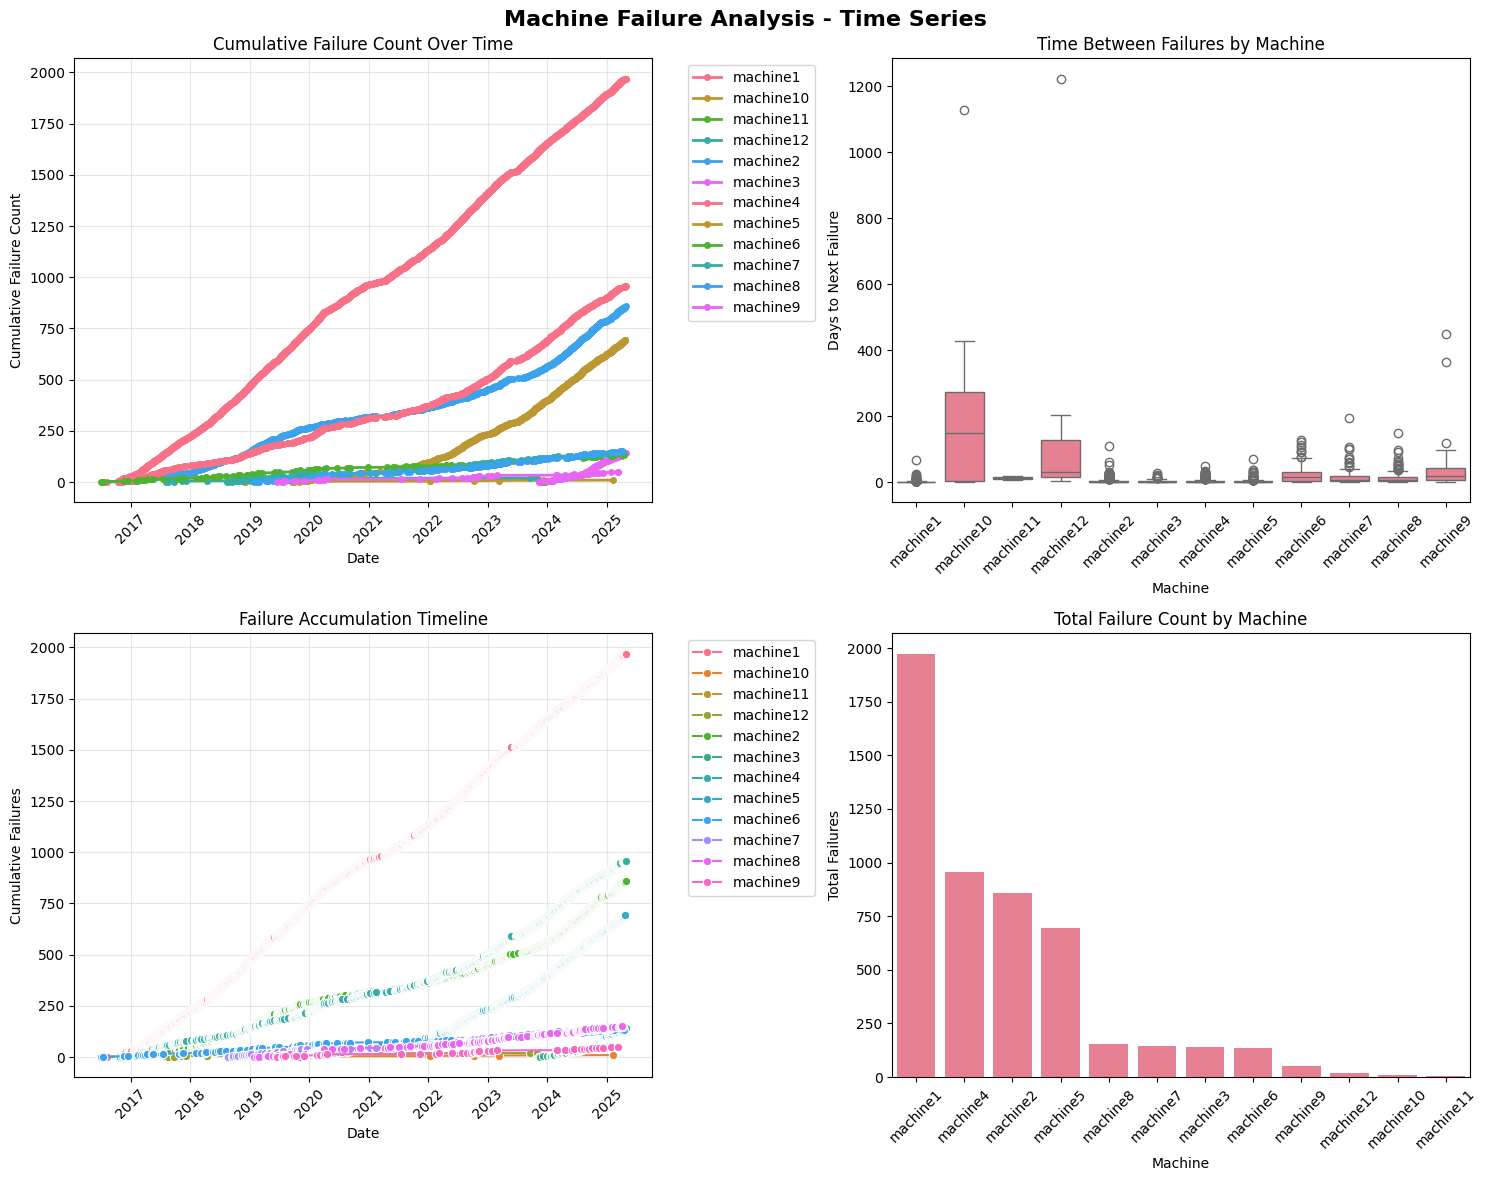

In [40]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Machine Failure Analysis - Time Series', fontsize=16, fontweight='bold')

# Plot 1: Failure Timeline by Machine
plt.sca(axes[0, 0])
for machine in failures['Désignation'].unique():
    machine_data = failures[failures['Désignation'] == machine]
    plt.plot(machine_data['Date intervention'], 
             machine_data['Failure_Count'], 
             marker='o', linewidth=2, markersize=4, label=machine)

plt.title('Cumulative Failure Count Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Failure Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Time Between Failures (Boxplot)
plt.sca(axes[0, 1])
sns.boxplot(data=failures, x='Désignation', y='Time_to_Next_Failure_Days', ax=axes[0, 1])
plt.title('Time Between Failures by Machine')
plt.xlabel('Machine')
plt.ylabel('Days to Next Failure')
plt.xticks(rotation=45)

# Additional Seaborn plot: Failure Trends
plt.sca(axes[1, 0])
sns.lineplot(data=failures, x='Date intervention', y='Failure_Count', 
             hue='Désignation', marker='o')
plt.title('Failure Accumulation Timeline')
plt.xlabel('Date')
plt.ylabel('Cumulative Failures')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 4: Failure Distribution by Machine
plt.sca(axes[1, 1])
failure_counts = failures['Désignation'].value_counts()
sns.barplot(x=failure_counts.index, y=failure_counts.values, ax=axes[1, 1])
plt.title('Total Failure Count by Machine')
plt.xlabel('Machine')
plt.ylabel('Total Failures')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [41]:
# Create a copy for visualization that handles NaN values
failures_viz = failures.copy()
failures_viz['Time_to_Next_Failure_Days_Filled'] = failures_viz['Time_to_Next_Failure_Days'].fillna(0)

# Plot 1: Interactive Failure Timeline
fig1 = px.line(failures_viz, x='Date intervention', y='Failure_Count', 
               color='Désignation', title='Interactive Failure Timeline',
               markers=True, template='plotly_white')
fig1.update_layout(
    xaxis_title='Date',
    yaxis_title='Cumulative Failure Count',
    hovermode='x unified'
)
fig1.show()

# Plot 2: Time Between Failures (Interactive Box Plot) - Exclude NaN
fig2 = px.box(failures_viz.dropna(subset=['Time_to_Next_Failure_Days']), 
              x='Désignation', y='Time_to_Next_Failure_Days',
              title='Time Between Failures Distribution (Excluding NaN)',
              color='Désignation', template='plotly_white')
fig2.update_layout(
    xaxis_title='Machine',
    yaxis_title='Days to Next Failure'
)
fig2.show()

# Plot 3: Calendar Heatmap of Failures
failures_viz['Date'] = failures_viz['Date intervention'].dt.date
daily_failures = failures_viz.groupby(['Date', 'Désignation']).size().reset_index(name='Failures')

fig3 = px.density_heatmap(daily_failures, x='Date', y='Désignation', z='Failures',
                         title='Daily Failure Heatmap',
                         color_continuous_scale='Viridis',
                         template='plotly_white')
fig3.update_layout(
    xaxis_title='Date',
    yaxis_title='Machine'
)
fig3.show()

# Plot 4: Machine Failure Statistics Dashboard
fig4 = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Failure Timeline', 'Time Between Failures', 
                   'Failure Distribution', 'Monthly Trends'),
    specs=[[{"type": "scatter"}, {"type": "box"}],
          [{"type": "bar"}, {"type": "scatter"}]]
)

# Subplot 1: Failure Timeline
for machine in failures_viz['Désignation'].unique():
    machine_data = failures_viz[failures_viz['Désignation'] == machine]
    fig4.add_trace(
        go.Scatter(x=machine_data['Date intervention'], 
                  y=machine_data['Failure_Count'],
                  name=machine, mode='lines+markers'),
        row=1, col=1
    )

# Subplot 2: Time Between Failures (exclude NaN)
for machine in failures_viz['Désignation'].unique():
    machine_data = failures_viz[(failures_viz['Désignation'] == machine) & 
                               (failures_viz['Time_to_Next_Failure_Days'].notna())]
    if not machine_data.empty:
        fig4.add_trace(
            go.Box(y=machine_data['Time_to_Next_Failure_Days'],
                   name=machine, showlegend=False),
            row=1, col=2
        )

# Subplot 3: Failure Distribution
failure_counts = failures_viz['Désignation'].value_counts()
fig4.add_trace(
    go.Bar(x=failure_counts.index, y=failure_counts.values,
           marker_color=px.colors.qualitative.Set3),
    row=2, col=1
)

# Subplot 4: Monthly Trends
monthly_totals = failures_viz.groupby(failures_viz['Date intervention'].dt.to_period('M')).size()
monthly_totals.index = monthly_totals.index.astype(str)
fig4.add_trace(
    go.Scatter(x=monthly_totals.index, y=monthly_totals.values,
               mode='lines+markers', name='Total Monthly Failures',
               line=dict(color='red', width=3)),
    row=2, col=2
)

fig4.update_layout(height=800, title_text="Machine Failure Analysis Dashboard",
                  template='plotly_white')
fig4.show()

# Plot 5: Fixed Interactive Failure Calendar - Use filled values
fig5 = px.scatter(failures_viz, x='Date intervention', y='Désignation',
                 color='Désignation', size='Time_to_Next_Failure_Days_Filled',
                 hover_data=['Time_to_Next_Failure_Days'],
                 title='Failure Events Calendar (Size = Days to Next Failure)',
                 template='plotly_white')
fig5.update_layout(
    xaxis_title='Date',
    yaxis_title='Machine'
)
fig5.show()

# Plot 6: Additional - Failure Intervals Over Time
fig6 = px.scatter(failures_viz.dropna(subset=['Time_to_Next_Failure_Days']),
                 x='Date intervention', y='Time_to_Next_Failure_Days',
                 color='Désignation', 
                 title='Time Between Failures Over Time',
                 labels={'Time_to_Next_Failure_Days': 'Days to Next Failure'},
                 template='plotly_white')
fig6.update_traces(marker=dict(size=8))
fig6.show()

In [36]:
# Calculate key statistics
print("=== MACHINE FAILURE STATISTICS ===")
print(f"Analysis Period: {failures['Date intervention'].min()} to {failures['Date intervention'].max()}")
print(f"Total Failure Events: {len(failures)}")
print(f"Number of Machines: {failures['Désignation'].nunique()}")
print("\nFailures per Machine:")
print(failures['Désignation'].value_counts())
print("\nAverage Time Between Failures (Days):")
print(failures.groupby('Désignation')['Time_to_Next_Failure_Days'].mean().round(2))

# Monthly statistics
monthly_stats = failures.groupby(failures['Date intervention'].dt.to_period('M')).agg({
    'Désignation': 'count',
    'Time_to_Next_Failure_Days': 'mean'
}).round(2)
monthly_stats.columns = ['Monthly_Failures', 'Avg_Days_Between_Failures']
print("\nMonthly Statistics:")
print(monthly_stats)

=== MACHINE FAILURE STATISTICS ===
Analysis Period: 2016-07-01 00:00:00 to 2025-04-25 00:00:00
Total Failure Events: 5138
Number of Machines: 12

Failures per Machine:
Désignation
machine1     1970
machine4      957
machine2      858
machine5      694
machine8      153
machine7      146
machine3      142
machine6      134
machine9       50
machine12      21
machine10      10
machine11       3
Name: count, dtype: int64

Average Time Between Failures (Days):
Désignation
machine1      1.63
machine10   250.44
machine11    13.00
machine12   113.70
machine2      3.74
machine3      3.76
machine4      3.25
machine5      2.95
machine6     24.14
machine7     16.75
machine8     14.85
machine9     42.65
Name: Time_to_Next_Failure_Days, dtype: float64

Monthly Statistics:
                   Monthly_Failures  Avg_Days_Between_Failures
Date intervention                                             
2016-07                           5                      55.80
2016-08                           1      

#### Downtime Duration :
Definition: Total hours a machine was down for a specific intervention.

In [43]:
downtime = df_gmao.groupby(['Date intervention', 'Désignation'])['Durée arrêt (h)'].max().reset_index()
downtime = downtime.rename(columns={'Durée arrêt (h)': 'Downtime_Duration_Hours'})
downtime

,Date intervention,Désignation,Downtime_Duration_Hours
0,01/01/2019,machine1,1.75
1,01/01/2020,machine1,0.42
2,01/01/2020,machine2,0.67
3,01/01/2023,machine1,12.75
4,01/01/2024,machine3,2.97
...,...,...,...
5133,31/12/2022,machine4,2.00
5134,31/12/2023,machine2,0.50
5135,31/12/2023,machine4,2.58
5136,31/12/2024,machine4,0.40


# KPIs

In [58]:
# For failures dataframe
failures = df_gmao[['Date intervention', 'Désignation']].drop_duplicates()
failures['Date intervention'] = pd.to_datetime(failures['Date intervention'], errors='coerce')
failures = failures.sort_values(['Désignation', 'Date intervention'])

# For downtime dataframe - ensure same data type
downtime = df_gmao.groupby(['Date intervention', 'Désignation'])['Durée arrêt (h)'].max().reset_index()
downtime = downtime.rename(columns={'Durée arrêt (h)': 'Downtime_Duration_Hours'})
downtime['Date intervention'] = pd.to_datetime(downtime['Date intervention'], errors='coerce')

# Check data types
print("Failures data types:")
print(failures.dtypes)
print("\nDowntime data types:")
print(downtime.dtypes)

# Merge failures with downtime
reliability_data = pd.merge(failures, downtime, on=['Date intervention', 'Désignation'], how='left')

print(f"\nMerged data shape: {reliability_data.shape}")
print("Sample of merged data:")
reliability_data.head()

Failures data types:
Date intervention    datetime64[ns]
Désignation                  object
dtype: object

Downtime data types:
Date intervention          datetime64[ns]
Désignation                        object
Downtime_Duration_Hours           float64
dtype: object

Merged data shape: (5138, 3)
Sample of merged data:


,Date intervention,Désignation,Downtime_Duration_Hours
0,2016-07-14,machine1,NaN
1,2016-08-08,machine1,NaN
2,2016-10-14,machine1,NaN
3,2016-10-18,machine1,NaN
4,2016-10-19,machine1,NaN


In [60]:
# Calculate time between failures
reliability_data = reliability_data.sort_values(['Désignation', 'Date intervention'])
reliability_data['Next_Failure_Date'] = reliability_data.groupby('Désignation')['Date intervention'].shift(-1)
reliability_data['Time_Between_Failures_Hours'] = (reliability_data['Next_Failure_Date'] - reliability_data['Date intervention']).dt.total_seconds() / 3600

print("Reliability Data with TBF:")
reliability_data[['Désignation', 'Date intervention', 'Downtime_Duration_Hours', 'Time_Between_Failures_Hours']].head(10)

Reliability Data with TBF:


,Désignation,Date intervention,Downtime_Duration_Hours,Time_Between_Failures_Hours
0,machine1,2016-07-14,NaN,600.00
1,machine1,2016-08-08,NaN,1608.00
2,machine1,2016-10-14,NaN,96.00
3,machine1,2016-10-18,NaN,24.00
4,machine1,2016-10-19,NaN,24.00
5,machine1,2016-10-20,NaN,96.00
6,machine1,2016-10-24,NaN,24.00
7,machine1,2016-10-25,NaN,48.00
8,machine1,2016-10-27,NaN,96.00
9,machine1,2016-10-31,NaN,24.00


In [62]:
def calculate_mtbf(data):
    """Calculate MTBF for each machine"""
    mtbf_results = []
    
    for machine in data['Désignation'].unique():
        machine_data = data[data['Désignation'] == machine]
        
        # Remove the last failure (no next failure date) and invalid values
        valid_tbf = machine_data.dropna(subset=['Time_Between_Failures_Hours'])
        valid_tbf = valid_tbf[valid_tbf['Time_Between_Failures_Hours'] > 0]
        
        if len(valid_tbf) > 0:
            mtbf = valid_tbf['Time_Between_Failures_Hours'].mean()
            mtbf_hours = mtbf
            mtbf_days = mtbf / 24
            
            mtbf_results.append({
                'Machine': machine,
                'MTBF_Hours': mtbf_hours,
                'MTBF_Days': mtbf_days,
                'Failure_Count': len(valid_tbf),
                'Total_Operating_Hours': valid_tbf['Time_Between_Failures_Hours'].sum()
            })
        else:
            print(f"Warning: No valid TBF data for machine {machine}")
    
    return pd.DataFrame(mtbf_results)

mtbf_df = calculate_mtbf(reliability_data)
print("MTBF Results:")
mtbf_df

MTBF Results:


,Machine,MTBF_Hours,MTBF_Days,Failure_Count,Total_Operating_Hours
0,machine1,39.09,1.63,1969,76968.00
1,machine10,6010.67,250.44,9,54096.00
2,machine11,312.00,13.00,2,624.00
3,machine12,2728.80,113.70,20,54576.00
4,machine2,89.73,3.74,857,76896.00
5,machine3,90.21,3.76,141,12720.00
6,machine4,78.03,3.25,956,74592.00
7,machine5,70.75,2.95,693,49032.00
8,machine6,579.43,24.14,133,77064.00
9,machine7,402.04,16.75,145,58296.00


In [63]:
def calculate_mttr(data):
    """Calculate MTTR for each machine"""
    mttr_results = []
    
    for machine in data['Désignation'].unique():
        machine_data = data[data['Désignation'] == machine]
        
        # Remove rows with zero, negative or missing downtime
        valid_downtime = machine_data[
            (machine_data['Downtime_Duration_Hours'].notna()) & 
            (machine_data['Downtime_Duration_Hours'] > 0)
        ]
        
        if len(valid_downtime) > 0:
            mttr = valid_downtime['Downtime_Duration_Hours'].mean()
            
            mttr_results.append({
                'Machine': machine,
                'MTTR_Hours': mttr,
                'Repair_Count': len(valid_downtime),
                'Total_Downtime_Hours': valid_downtime['Downtime_Duration_Hours'].sum()
            })
        else:
            print(f"Warning: No valid downtime data for machine {machine}")
    
    return pd.DataFrame(mttr_results)

mttr_df = calculate_mttr(reliability_data)
print("\nMTTR Results:")
mttr_df


MTTR Results:


,Machine,MTTR_Hours,Repair_Count,Total_Downtime_Hours
0,machine1,32.89,489,16084.92
1,machine2,15.78,121,1909.45
2,machine3,3.24,10,32.38
3,machine4,14.15,150,2122.88
4,machine5,40.29,129,5197.28
5,machine6,15.11,9,136.03
6,machine7,1.17,5,5.83
7,machine8,1.42,7,9.97
8,machine9,58.06,3,174.17


In [64]:
def calculate_availability(mtbf_df, mttr_df):
    """Calculate Availability for each machine"""
    availability_results = []
    
    # Get all unique machines from both dataframes
    all_machines = set(mtbf_df['Machine']).union(set(mttr_df['Machine']))
    
    for machine in all_machines:
        mtbf_data = mtbf_df[mtbf_df['Machine'] == machine]
        mttr_data = mttr_df[mttr_df['Machine'] == machine]
        
        if not mtbf_data.empty and not mttr_data.empty:
            mtbf = mtbf_data['MTBF_Hours'].iloc[0]
            mttr = mttr_data['MTTR_Hours'].iloc[0]
            
            # Availability = MTBF / (MTBF + MTTR)
            if (mtbf + mttr) > 0:
                availability = mtbf / (mtbf + mttr)
                availability_percent = availability * 100
            else:
                availability = 0
                availability_percent = 0
            
            availability_results.append({
                'Machine': machine,
                'Availability': availability,
                'Availability_Percent': availability_percent,
                'MTBF_Hours': mtbf,
                'MTTR_Hours': mttr
            })
        else:
            print(f"Warning: Missing data for machine {machine}")
    
    return pd.DataFrame(availability_results)

availability_df = calculate_availability(mtbf_df, mttr_df)
print("\nAvailability Results:")
availability_df


Availability Results:


,Machine,Availability,Availability_Percent,MTBF_Hours,MTTR_Hours
0,machine2,0.85,85.04,89.73,15.78
1,machine7,1.00,99.71,402.04,1.17
2,machine6,0.97,97.46,579.43,15.11
3,machine9,0.95,94.63,1023.67,58.06
4,machine8,1.00,99.60,356.37,1.42
5,machine4,0.85,84.65,78.03,14.15
6,machine1,0.54,54.30,39.09,32.89
7,machine3,0.97,96.53,90.21,3.24
8,machine5,0.64,63.72,70.75,40.29


In [75]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plot 1: MTBF and MTTR Comparison
fig1 = make_subplots(
    rows=1, cols=2,
    subplot_titles=('MTBF by Machine (Hours)', 'MTTR by Machine (Hours)')
)

fig1.add_trace(
    go.Bar(x=availability_df['Machine'], 
           y=availability_df['MTBF_Hours'], 
           name='MTBF', marker_color='green'),
    row=1, col=1
)

fig1.add_trace(
    go.Bar(x=availability_df['Machine'], 
           y=availability_df['MTTR_Hours'], 
           name='MTTR', marker_color='red'),
    row=1, col=2
)

fig1.update_layout(
    title_text='MTBF vs MTTR Comparison',
    template='plotly_white',
    height=400
)
fig1.show()

# Plot 2: Availability
fig2 = px.bar(availability_df, 
              x='Machine', 
              y='Availability_Percent',
              title='Machine Availability (%)',
              color='Availability_Percent',
              color_continuous_scale='RdYlGn')

fig2.update_layout(
    yaxis_title='Availability (%)',
    template='plotly_white',
    height=400
)
fig2.show()

In [76]:
# Prepare the data
failures = df_gmao[['Date intervention', 'Désignation']].drop_duplicates()
failures['Date intervention'] = pd.to_datetime(failures['Date intervention'], errors='coerce')
failures = failures.sort_values(['Désignation', 'Date intervention'])

downtime = df_gmao.groupby(['Date intervention', 'Désignation'])['Durée arrêt (h)'].max().reset_index()
downtime = downtime.rename(columns={'Durée arrêt (h)': 'Downtime_Duration_Hours'})
downtime['Date intervention'] = pd.to_datetime(downtime['Date intervention'], errors='coerce')

# Merge using string approach to avoid data type issues
failures_str = failures.copy()
downtime_str = downtime.copy()
failures_str['Date_intervention_str'] = failures_str['Date intervention'].astype(str)
downtime_str['Date_intervention_str'] = downtime_str['Date intervention'].astype(str)

reliability_data = pd.merge(failures_str, downtime_str, 
                           left_on=['Date_intervention_str', 'Désignation'],
                           right_on=['Date_intervention_str', 'Désignation'], 
                           how='left')
reliability_data['Date intervention'] = pd.to_datetime(reliability_data['Date_intervention_str'])
reliability_data = reliability_data.drop('Date_intervention_str', axis=1)

# Calculate Time Between Failures
reliability_data = reliability_data.sort_values(['Désignation', 'Date intervention'])
reliability_data['Next_Failure_Date'] = reliability_data.groupby('Désignation')['Date intervention'].shift(-1)
reliability_data['Time_Between_Failures_Hours'] = (reliability_data['Next_Failure_Date'] - reliability_data['Date intervention']).dt.total_seconds() / 3600

# Add month-year column for monthly analysis
reliability_data['YearMonth'] = reliability_data['Date intervention'].dt.to_period('M')
reliability_data['Year'] = reliability_data['Date intervention'].dt.year
reliability_data['Month'] = reliability_data['Date intervention'].dt.month
reliability_data['MonthName'] = reliability_data['Date intervention'].dt.strftime('%b %Y')

print("Monthly reliability data prepared:")
reliability_data[['Désignation', 'Date intervention', 'YearMonth', 'Downtime_Duration_Hours', 'Time_Between_Failures_Hours']].head()


Monthly reliability data prepared:


,Désignation,Date intervention,YearMonth,Downtime_Duration_Hours,Time_Between_Failures_Hours
0,machine1,2016-07-14,2016-07,NaN,600.00
1,machine1,2016-08-08,2016-08,NaN,1608.00
2,machine1,2016-10-14,2016-10,NaN,96.00
3,machine1,2016-10-18,2016-10,NaN,24.00
4,machine1,2016-10-19,2016-10,NaN,24.00


In [78]:
def calculate_monthly_reliability_metrics(data):
    """Calculate monthly MTBF, MTTR, and Availability for each machine"""
    monthly_metrics = []
    
    for machine in data['Désignation'].unique():
        machine_data = data[data['Désignation'] == machine]
        
        for month in machine_data['YearMonth'].unique():
            month_data = machine_data[machine_data['YearMonth'] == month]
            
            # Calculate monthly MTBF
            valid_tbf = month_data.dropna(subset=['Time_Between_Failures_Hours'])
            valid_tbf = valid_tbf[valid_tbf['Time_Between_Failures_Hours'] > 0]
            monthly_mtbf = valid_tbf['Time_Between_Failures_Hours'].mean() if len(valid_tbf) > 0 else 0
            
            # Calculate monthly MTTR
            valid_downtime = month_data[
                (month_data['Downtime_Duration_Hours'].notna()) & 
                (month_data['Downtime_Duration_Hours'] > 0)
            ]
            monthly_mttr = valid_downtime['Downtime_Duration_Hours'].mean() if len(valid_downtime) > 0 else 0
            
            # Calculate monthly Availability
            if monthly_mtbf > 0 and monthly_mttr > 0:
                monthly_availability = (monthly_mtbf / (monthly_mtbf + monthly_mttr)) * 100
            else:
                monthly_availability = 0
            
            monthly_metrics.append({
                'Machine': machine,
                'YearMonth': month,
                'Year': month_data['Year'].iloc[0] if len(month_data) > 0 else 0,
                'Month': month_data['Month'].iloc[0] if len(month_data) > 0 else 0,
                'MonthName': month_data['MonthName'].iloc[0] if len(month_data) > 0 else '',
                'MTBF_Hours': monthly_mtbf,
                'MTTR_Hours': monthly_mttr,
                'Availability_Percent': monthly_availability,
                'Failure_Count': len(month_data),
                'Total_Downtime_Hours': valid_downtime['Downtime_Duration_Hours'].sum() if len(valid_downtime) > 0 else 0
            })
    
    monthly_df = pd.DataFrame(monthly_metrics)
    monthly_df['YearMonth'] = monthly_df['YearMonth'].astype(str)
    
    return monthly_df

monthly_reliability = calculate_monthly_reliability_metrics(reliability_data)
print("Monthly Reliability Metrics:")
print(f"\nTotal monthly records: {len(monthly_reliability)}")

Monthly Reliability Metrics:

Total monthly records: 633


In [79]:
monthly_reliability.head(10)

,Machine,YearMonth,Year,Month,MonthName,MTBF_Hours,MTTR_Hours,Availability_Percent,Failure_Count,Total_Downtime_Hours
0,machine1,2016-07,2016,7,Jul 2016,600.00,0.00,0.00,1,0.00
1,machine1,2016-08,2016,8,Aug 2016,1608.00,0.00,0.00,1,0.00
2,machine1,2016-10,2016,10,Oct 2016,54.00,0.00,0.00,8,0.00
3,machine1,2016-11,2016,11,Nov 2016,91.64,0.00,0.00,11,0.00
4,machine1,2016-12,2016,12,Dec 2016,68.57,0.00,0.00,7,0.00
5,machine1,2017-01,2017,1,Jan 2017,65.45,9.56,87.26,11,28.67
6,machine1,2017-02,2017,2,Feb 2017,67.20,5.21,92.81,10,10.42
7,machine1,2017-03,2017,3,Mar 2017,39.60,4.60,89.59,20,23.00
8,machine1,2017-04,2017,4,Apr 2017,36.63,10.25,78.14,19,20.50
9,machine1,2017-05,2017,5,May 2017,42.35,21.40,66.43,17,64.20


In [80]:
# Plot 1: Monthly Availability Trends for All Machines
fig1 = px.line(monthly_reliability, 
               x='YearMonth', 
               y='Availability_Percent',
               color='Machine',
               title='Monthly Machine Availability Trends',
               markers=True,
               template='plotly_white')

fig1.update_layout(
    xaxis_title='Month',
    yaxis_title='Availability (%)',
    xaxis=dict(tickangle=45),
    height=500,
    hovermode='x unified'
)
fig1.show()

# Plot 2: Monthly MTBF Trends
fig2 = px.line(monthly_reliability, 
               x='YearMonth', 
               y='MTBF_Hours',
               color='Machine',
               title='Monthly MTBF Trends (Mean Time Between Failures)',
               markers=True,
               template='plotly_white')

fig2.update_layout(
    xaxis_title='Month',
    yaxis_title='MTBF (Hours)',
    xaxis=dict(tickangle=45),
    height=500,
    hovermode='x unified'
)
fig2.show()

# Plot 3: Monthly MTTR Trends
fig3 = px.line(monthly_reliability, 
               x='YearMonth', 
               y='MTTR_Hours',
               color='Machine',
               title='Monthly MTTR Trends (Mean Time To Repair)',
               markers=True,
               template='plotly_white')

fig3.update_layout(
    xaxis_title='Month',
    yaxis_title='MTTR (Hours)',
    xaxis=dict(tickangle=45),
    height=500,
    hovermode='x unified'
)
fig3.show()

In [81]:
# Create pivot tables for heatmaps
availability_pivot = monthly_reliability.pivot_table(
    index='YearMonth', 
    columns='Machine', 
    values='Availability_Percent',
    fill_value=0
)

mtbf_pivot = monthly_reliability.pivot_table(
    index='YearMonth', 
    columns='Machine', 
    values='MTBF_Hours',
    fill_value=0
)

mttr_pivot = monthly_reliability.pivot_table(
    index='YearMonth', 
    columns='Machine', 
    values='MTTR_Hours',
    fill_value=0
)

# Plot 4: Availability Heatmap
fig4 = px.imshow(availability_pivot.T,
                title='Monthly Availability Heatmap (%)',
                color_continuous_scale='RdYlGn',
                aspect='auto',
                template='plotly_white')

fig4.update_layout(
    xaxis_title='Month',
    yaxis_title='Machine',
    height=500
)
fig4.show()

# Plot 5: MTBF Heatmap
fig5 = px.imshow(mtbf_pivot.T,
                title='Monthly MTBF Heatmap (Hours)',
                color_continuous_scale='Blues',
                aspect='auto',
                template='plotly_white')

fig5.update_layout(
    xaxis_title='Month',
    yaxis_title='Machine',
    height=500
)
fig5.show()

# Plot 6: MTTR Heatmap
fig6 = px.imshow(mttr_pivot.T,
                title='Monthly MTTR Heatmap (Hours)',
                color_continuous_scale='Reds',
                aspect='auto',
                template='plotly_white')

fig6.update_layout(
    xaxis_title='Month',
    yaxis_title='Machine',
    height=500
)
fig6.show()

In [82]:
# Plot 7: Monthly Comparison Dashboard
fig7 = make_subplots(
    rows=3, cols=1,
    subplot_titles=('Monthly Availability (%)', 'Monthly MTBF (Hours)', 'Monthly MTTR (Hours)'),
    shared_xaxes=True,
    vertical_spacing=0.08
)

# Get unique machines and colors
machines = monthly_reliability['Machine'].unique()
colors = px.colors.qualitative.Set1

for i, machine in enumerate(machines):
    machine_data = monthly_reliability[monthly_reliability['Machine'] == machine]
    
    # Availability
    fig7.add_trace(
        go.Scatter(x=machine_data['YearMonth'], 
                  y=machine_data['Availability_Percent'],
                  name=f'{machine} - Availability',
                  mode='lines+markers',
                  line=dict(color=colors[i % len(colors)]),
                  legendgroup=machine),
        row=1, col=1
    )
    
    # MTBF
    fig7.add_trace(
        go.Scatter(x=machine_data['YearMonth'], 
                  y=machine_data['MTBF_Hours'],
                  name=f'{machine} - MTBF',
                  mode='lines+markers',
                  line=dict(color=colors[i % len(colors)], dash='dot'),
                  legendgroup=machine,
                  showlegend=False),
        row=2, col=1
    )
    
    # MTTR
    fig7.add_trace(
        go.Scatter(x=machine_data['YearMonth'], 
                  y=machine_data['MTTR_Hours'],
                  name=f'{machine} - MTTR',
                  mode='lines+markers',
                  line=dict(color=colors[i % len(colors)], dash='dash'),
                  legendgroup=machine,
                  showlegend=False),
        row=3, col=1
    )

fig7.update_layout(
    title_text='Monthly Reliability Metrics Dashboard',
    template='plotly_white',
    height=800,
    hovermode='x unified'
)

fig7.update_xaxes(tickangle=45, row=3, col=1)
fig7.show()

In [83]:
# Plot 8: Individual Machine Monthly Analysis
for machine in monthly_reliability['Machine'].unique():
    machine_data = monthly_reliability[monthly_reliability['Machine'] == machine]
    
    fig8 = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            f'{machine} - Monthly Availability', 
            f'{machine} - Monthly MTBF vs MTTR',
            f'{machine} - Failure Count',
            f'{machine} - Total Downtime'
        ),
        specs=[[{"type": "bar"}, {"type": "scatter"}],
              [{"type": "bar"}, {"type": "bar"}]]
    )
    
    # Availability
    fig8.add_trace(
        go.Bar(x=machine_data['YearMonth'], 
               y=machine_data['Availability_Percent'],
               name='Availability',
               marker_color='green'),
        row=1, col=1
    )
    
    # MTBF vs MTTR
    fig8.add_trace(
        go.Scatter(x=machine_data['YearMonth'], 
                  y=machine_data['MTBF_Hours'],
                  name='MTBF',
                  mode='lines+markers',
                  line=dict(color='blue')),
        row=1, col=2
    )
    
    fig8.add_trace(
        go.Scatter(x=machine_data['YearMonth'], 
                  y=machine_data['MTTR_Hours'],
                  name='MTTR',
                  mode='lines+markers',
                  line=dict(color='red')),
        row=1, col=2
    )
    
    # Failure Count
    fig8.add_trace(
        go.Bar(x=machine_data['YearMonth'], 
               y=machine_data['Failure_Count'],
               name='Failures',
               marker_color='orange'),
        row=2, col=1
    )
    
    # Total Downtime
    fig8.add_trace(
        go.Bar(x=machine_data['YearMonth'], 
               y=machine_data['Total_Downtime_Hours'],
               name='Downtime',
               marker_color='red'),
        row=2, col=2
    )
    
    fig8.update_layout(
        title_text=f'{machine} - Monthly Reliability Analysis',
        template='plotly_white',
        height=600,
        showlegend=True
    )
    
    fig8.update_xaxes(tickangle=45)
    fig8.show()

In [91]:
logger.info("Generating monthly reliability statistics...")

try:
    # Monthly statistics
    logger.info("=== MONTHLY RELIABILITY STATISTICS ===")
    monthly_stats = monthly_reliability.groupby('YearMonth').agg({
        'Availability_Percent': ['mean', 'min', 'max'],
        'MTBF_Hours': 'mean',
        'MTTR_Hours': 'mean',
        'Failure_Count': 'sum',
        'Total_Downtime_Hours': 'sum'
    }).round(2)

    monthly_stats.columns = ['Avg_Availability', 'Min_Availability', 'Max_Availability', 
                            'Avg_MTBF', 'Avg_MTTR', 'Total_Failures', 'Total_Downtime']
    
    logger.info("Monthly Statistics Summary:")
    logger.info(f"\n{monthly_stats}")

    # Machine-specific monthly performance
    logger.info("=== BEST AND WORST MONTHLY PERFORMANCE BY MACHINE ===")
    performance_summary = []

    for machine in monthly_reliability['Machine'].unique():
        machine_data = monthly_reliability[monthly_reliability['Machine'] == machine]
        
        if not machine_data.empty:
            best_month = machine_data.loc[machine_data['Availability_Percent'].idxmax()]
            worst_month = machine_data.loc[machine_data['Availability_Percent'].idxmin()]
            
            performance_summary.append({
                'Machine': machine,
                'Best_Month': best_month['YearMonth'],
                'Best_Availability': best_month['Availability_Percent'],
                'Worst_Month': worst_month['YearMonth'],
                'Worst_Availability': worst_month['Availability_Percent'],
                'Avg_Availability': machine_data['Availability_Percent'].mean()
            })
            
            logger.info(f"{machine}:")
            logger.info(f"  Best Month: {best_month['YearMonth']} - {best_month['Availability_Percent']:.1f}% availability")
            logger.info(f"  Worst Month: {worst_month['YearMonth']} - {worst_month['Availability_Percent']:.1f}% availability")
            logger.info(f"  Average Availability: {machine_data['Availability_Percent'].mean():.1f}%")

    # Overall statistics
    logger.info("=== OVERALL MONTHLY PERFORMANCE ===")
    logger.info(f"Average Monthly Availability: {monthly_reliability['Availability_Percent'].mean():.1f}%")
    logger.info(f"Average Monthly MTBF: {monthly_reliability['MTBF_Hours'].mean():.1f} hours")
    logger.info(f"Average Monthly MTTR: {monthly_reliability['MTTR_Hours'].mean():.1f} hours")
    logger.info(f"Total Failures Recorded: {monthly_reliability['Failure_Count'].sum()}")
    logger.info(f"Total Downtime Hours: {monthly_reliability['Total_Downtime_Hours'].sum():.1f}")

except Exception as e:
    logger.error(f"Failed to generate statistics: {e}")

2025-11-22 13:09:34 | INFO     | __main__:<module>:1 - Generating monthly reliability statistics...
2025-11-22 13:09:34 | INFO     | __main__:<module>:5 - === MONTHLY RELIABILITY STATISTICS ===
2025-11-22 13:09:34 | INFO     | __main__:<module>:17 - Monthly Statistics Summary:
2025-11-22 13:09:34 | INFO     | __main__:<module>:18 - 
           Avg_Availability  Min_Availability  Max_Availability  Avg_MTBF  \
YearMonth                                                                   
2016-07                0.00              0.00              0.00   1458.67   
2016-08                0.00              0.00              0.00   1608.00   
2016-10                0.00              0.00              0.00    153.00   
2016-11               24.95              0.00             99.80    377.91   
2016-12                0.00              0.00              0.00    670.29   
...                     ...               ...               ...       ...   
2024-12               68.54              0.00    

In [85]:
# Plot 9: Trend Analysis
monthly_reliability['YearMonthDate'] = pd.to_datetime(monthly_reliability['YearMonth'] + '-01')

# Calculate 3-month moving average for each machine
trend_data = monthly_reliability.copy()
trend_data = trend_data.sort_values(['Machine', 'YearMonthDate'])

trend_data['Availability_MA3'] = trend_data.groupby('Machine')['Availability_Percent'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

fig9 = px.line(trend_data, 
               x='YearMonthDate', 
               y=['Availability_Percent', 'Availability_MA3'],
               color='Machine',
               facet_row='Machine',
               title='Monthly Availability Trends with 3-Month Moving Average',
               template='plotly_white')

fig9.update_layout(
    xaxis_title='Month',
    yaxis_title='Availability (%)',
    height=800
)
fig9.show()

# ================ FORECAST =================